# Project: ASD Classification using fMRI Functional Connectivity and Machine Learning

Author: Arife Nur

Dataset: ABIDE I (Preprocessed Connectomes Project - CPAC, filt_noglobal)
**Primary Derivative:** ROI-based time series (from CC200 atlas)

## 1. Aim of the Notebook

This notebook aims to develop and evaluate machine learning models for the classification of Autism Spectrum Disorder (ASD) versus Typically Developing (TD) individuals using resting-state functional magnetic resonance imaging (rs-fMRI) data.

The primary objectives are:
1.  To preprocess and extract functional connectivity (FC) features from rs-fMRI time series data obtained from the ABIDE I dataset. This will involve calculating correlation matrices between predefined Regions of Interest (ROIs).
2.  To systematically explore, train, and evaluate various machine learning classifiers ( Support Vector Machines, Random Forests, Gradient Boosting, potentially Neural Networks) for distinguishing between ASD and TD groups based on these FC features.
3.  To identify potential challenges such as high dimensionality of data, dataset imbalances, and inter-site variability, and implement strategies to mitigate them.
4.  To perform rigorous model evaluation using cross-validation techniques to assess generalization performance and report relevant metrics (accuracy, sensitivity, specificity, AUC-ROC).
5.  To investigate and interpret the most discriminative functional connections or network features contributing to the classification, thereby offering insights into the neural underpinnings of ASD.

This work contributes to the ongoing effort to identify objective neuroimaging-based biomarkers for ASD, with the ultimate goal of aiding in early diagnosis and understanding the disorder's neurobiology. All steps, including data loading, preprocessing, feature engineering, model training, and evaluation, will be documented within this notebook.

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 26.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Downloading The Data From ABIDE Into Drive

In [ ]:
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2 #filter criteria
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'#data path
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv']) #phenotypic csv path

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []#we will create paths list in the drive for each file
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:#which was a filter with value of 0.2
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):#since our labels are 1 for ASD and 2 for TD
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)#to remove the https address from the begining
        download_file = os.path.join(out_dir, rel_path)# out_dir is the output directory where we intend to save our files, rel_path is the relative path of the file.
        download_dir = os.path.dirname(download_file)#directory path
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_cc200'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_noglobal'  # Noise-removal strategy used during preprocessing
download_data_dir = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal'  # Path to drive where the downloaded data will be saved
desired_diagnosis = 'both'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import pandas as pd
from nilearn import connectome
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
pheno_df = pd.read_csv(pheno_file_path)


pheno_df = pheno_df[['FILE_ID', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX', 'SITE_ID', 'func_mean_fd']]

# Convert DX_GROUP to 0 (TD) and 1 (ASD)
# Normally ASD --> 1, TD --> 2
pheno_df['label'] = pheno_df['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

In [ ]:
def load_timeseries(file_path):
    """Loads a .1D file into a NumPy array."""
    try:
        timeseries = np.loadtxt(file_path)
        return timeseries
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [ ]:
#--Pearson Correlation--
connectivity_measure = connectome.ConnectivityMeasure(kind='correlation', vectorize=False) # vectorize=False gives the full matrix
all_fc_matrices = []
subject_ids_for_model = []
labels_for_model = []

base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'

for index, row in pheno_df.iterrows():
    file_id = row['FILE_ID']
    label = row['label']

    subject_file_path = os.path.join(base_1d_files_path, f"{file_id}_{derivative_name}.1D")

    if not os.path.exists(subject_file_path):
        print(f"File not found for {file_id}, skipping.")
        continue

    timeseries = load_timeseries(subject_file_path)
    if timeseries is not None and timeseries.shape[0] > timeseries.shape[1]: # Basic check: more timepoints than ROIs, checks if the number of rows(time points) is greater than the number of columns(features, variables, or different channels/sensors.).
        # Nilearn expects timeseries as (n_samples, n_features, n_subjects) or list of (n_samples, n_features)
        # For a single subject, it needs to be reshaped or put in a list
        fc_matrix = connectivity_measure.fit_transform([timeseries])[0]# this primarily involves estimating the covariance matrix from the input time series.
        all_fc_matrices.append(fc_matrix)
        subject_ids_for_model.append(file_id)
        labels_for_model.append(label)
    else:
        print(f"Skipping {file_id} due to problematic timeseries shape or loading error.")


all_fc_matrices = np.array(all_fc_matrices)
y = np.array(labels_for_model)
print(f"Processed FC matrices for {len(all_fc_matrices)} subjects. Shape of one FC matrix: {all_fc_matrices[0].shape if len(all_fc_matrices) > 0 else 'N/A'}")
print(f"Shape of y: {y.shape}")

File not found for no_filename, skipping.
File not found for Pitt_0050003, skipping.
Skipping Pitt_0050004 due to problematic timeseries shape or loading error.
Skipping Pitt_0050005 due to problematic timeseries shape or loading error.
Skipping Pitt_0050006 due to problematic timeseries shape or loading error.
Skipping Pitt_0050007 due to problematic timeseries shape or loading error.
Skipping Pitt_0050008 due to problematic timeseries shape or loading error.
Skipping Pitt_0050009 due to problematic timeseries shape or loading error.
Skipping Pitt_0050010 due to problematic timeseries shape or loading error.
Skipping Pitt_0050011 due to problematic timeseries shape or loading error.
Skipping Pitt_0050012 due to problematic timeseries shape or loading error.
File not found for Pitt_0050013, skipping.
Skipping Pitt_0050014 due to problematic timeseries shape or loading error.
Skipping Pitt_0050015 due to problematic timeseries shape or loading error.
Skipping Pitt_0050016 due to problem

Output= Processed FC matrices for 285 subjects.

Here, the first problem occurs:

ABIDE has around 1000 (and the download script likely aimed for many more that passed its QC) means there's a significant data loss somewhere in the pipeline from downloading to FC matrix calculation.

## Problem Inspect

1. Verify the Path to the .1D Files

In [ ]:
base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'

# Test with one known FILE_ID from the pheno_df
test_file_id = pheno_df['FILE_ID'].iloc[0] # Get the first file_id as a test
expected_file_path = os.path.join(base_1d_files_path, f"{test_file_id}_{derivative_name}.1D")
print(f"Testing for file: {expected_file_path}")
print(f"Does it exist? {os.path.exists(expected_file_path)}")

# Also, list what's actually in that directory:
try:
    print(f"\nFirst 5 files found in '{base_1d_files_path}':")
    print(os.listdir(base_1d_files_path)[:5])
except FileNotFoundError:
    print(f"ERROR: The directory '{base_1d_files_path}' itself was not found! This is likely the main problem.")

Testing for file: /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/no_filename_rois_cc200.1D
Does it exist? False

First 5 files found in '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/':
['Pitt_0050004_rois_cc200.1D', 'Pitt_0050005_rois_cc200.1D', 'Pitt_0050006_rois_cc200.1D', 'Pitt_0050007_rois_cc200.1D', 'Pitt_0050008_rois_cc200.1D']


This means many of the "skipped files" are likely due to the script trying to find files based on FILE_IDs from the phenotypic sheet that don't actually have a corresponding downloaded .1D file in the target folder.

And it is because we eliminated some files at the begining without deleting the corresponding ID.

It means that the first file (and many others) did not pass the quality control check during the download phase, so its .1D file was never downloaded.

In [ ]:
base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'


all_filenames_in_dir = os.listdir(base_1d_files_path)

# Extract FILE_IDs from the filenames that match the derivative
# filenames are in the "SUBJECTID_derivativetype.1D" structure
available_file_ids = set()
for filename in all_filenames_in_dir:
    if filename.endswith(f"_{derivative_name}.1D"):
        file_id = filename.replace(f"_{derivative_name}.1D", "")
        available_file_ids.add(file_id)

print(f"Found {len(available_file_ids)} unique .1D files in the directory.")
if len(available_file_ids) > 0:
    print(f"Example available FILE_ID: {list(available_file_ids)[0]}")

Found 884 unique .1D files in the directory.
Example available FILE_ID: USM_0050529


In [ ]:
pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
pheno_df_full = pd.read_csv(pheno_file_path)
pheno_df_full = pheno_df_full[pheno_df_full['FILE_ID'] != 'no_filename']
# Initial number of subjects in the phenotypic file
print(f"Total subjects in original phenotypic file (after basic 'no_filename' filter): {len(pheno_df_full)}")

Total subjects in original phenotypic file (after basic 'no_filename' filter): 1035


In [ ]:
# Filter the phenotypic DataFrame
pheno_df_filtered = pheno_df_full[pheno_df_full['FILE_ID'].isin(available_file_ids)].copy()


# DX_GROUP: 1 is ASD, 2 is TD.
pheno_df_filtered['label'] = pheno_df_filtered['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

print(f"Number of subjects after matching with available .1D files: {len(pheno_df_filtered)}")
print(f"Number of ASD subjects available: {pheno_df_filtered[pheno_df_filtered['label'] == 1].shape[0]}")
print(f"Number of TD subjects available: {pheno_df_filtered[pheno_df_filtered['label'] == 0].shape[0]}")

Number of subjects after matching with available .1D files: 884
Number of ASD subjects available: 408
Number of TD subjects available: 476


This output tells us that:

1. We have 884 potential subjects: our code correctly identified 884 .1D files in the Google Drive directory that also have corresponding entries in the phenotypic data. This is a good number to potentially work with.
2. The main issue is data integrity: A very large number of these existing files (599 out of 884) are failing to load or pass the filters. This is why only 285 subjects are making it through to the FC calculation.

 We basically have inconsistent data shapes

With this data in hand, we have three possibilities:

1. The `load_timeseries` function facing some incompatibility with loading NumPy arrays,

2. The functional connectivity measurement filters out elements that make up most of the data,

3. The condition we set up of having TRs<ROIs is the reason most of the subjects are being filtered out.

### let's analyze one of the failed files to delve more into the problem:

In [ ]:
problem_file_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/MaxMun_a_0051607_rois_cc200.1D'
try:
    file_size = os.path.getsize(problem_file_path)
    print(f"File size of {problem_file_path}: {file_size} bytes")
except FileNotFoundError:
    print(f"File not found: {problem_file_path}") # Should not happen if it's from the 884 list
except Exception as e:
    print(f"Error getting file size: {e}")

File size of /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/MaxMun_a_0051607_rois_cc200.1D: 232970 bytes


In [ ]:
problem_file_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/MaxMun_a_0051607_rois_cc200.1D'
try:
    with open(problem_file_path, 'r') as f:
        print(f"\nFirst 5 lines of {problem_file_path}:")
        for i in range(5):
            line = f.readline()
            if not line: # Stop if end of file is reached early
                print("-- End of File --")
                break
            print(line.strip()) # .strip() removes leading/trailing whitespace including newlines
except Exception as e:
    print(f"Error opening/reading file {problem_file_path}: {e}")


First 5 lines of /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/MaxMun_a_0051607_rois_cc200.1D:
#1	#2	#3	#4	#5	#6	#7	#8	#9	#10	#11	#12	#13	#14	#15	#16	#17	#18	#19	#20	#21	#22	#23	#24	#25	#26	#27	#28	#29	#30	#31	#32	#33	#34	#35	#36	#37	#38	#39	#40	#41	#42	#43	#44	#45	#46	#47	#48	#49	#50	#51	#52	#53	#54	#55	#56	#57	#58	#59	#60	#61	#62	#63	#64	#65	#66	#67	#68	#69	#70	#71	#72	#73	#74	#75	#76	#77	#78	#79	#80	#81	#82	#83	#84	#85	#86	#87	#88	#89	#90	#91	#92	#93	#94	#95	#96	#97	#98	#99	#100	#101	#102	#103	#104	#105	#106	#107	#108	#109	#110	#111	#112	#113	#114	#115	#116	#117	#118	#119	#120	#121	#122	#123	#124	#125	#126	#127	#128	#129	#130	#131	#132	#133	#134	#135	#136	#137	#138	#139	#140	#141	#142	#143	#144	#145	#146	#147	#148	#149	#150	#151	#152	#153	#154	#155	#156	#157	#158	#159	#160	#161	#162	#163	#164	#165	#166	#167	#168	#169	#170	#171	#172	#173	#174	#175	#176	#177	#178	#179	#180	#181	#182	#183	#184	#185	#186	#1

1. File is NOT Empty or Corrupted:

- File size (232970 bytes) indicates it contains substantial data.
The first few lines show numerical data, which is what we expect for a time series.

2. Header Line is Standard

3. Confirmation of the Skipping Reason for THIS File:
- The file was subsequently skipped because this shape failed the validation check, specifically timeseries.shape[0] < timeseries.shape[1] (i.e., 116 TRs < 200 ROIs).

This means the third possibility is indeed the reason for this problem.


## Plotting TR Counts vs Subject Counts

In [ ]:
#----getting the phenotypic file again in case the above codes are not in run-----
import os
base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'
all_filenames_in_dir = os.listdir(base_1d_files_path)

available_file_ids = set()
for filename in all_filenames_in_dir:
    if filename.endswith(f"_{derivative_name}.1D"):
        file_id = filename.replace(f"_{derivative_name}.1D", "")
        available_file_ids.add(file_id)

pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
pheno_df_full = pd.read_csv(pheno_file_path)
pheno_df_full = pheno_df_full[pheno_df_full['FILE_ID'] != 'no_filename']

pheno_df_filtered = pheno_df_full[pheno_df_full['FILE_ID'].isin(available_file_ids)].copy()

# DX_GROUP: 1 is ASD, 2 is TD.
pheno_df_filtered['label'] = pheno_df_filtered['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

Attempting to load shapes for TR count distribution...
Successfully got TR counts for 884 out of 884 files.


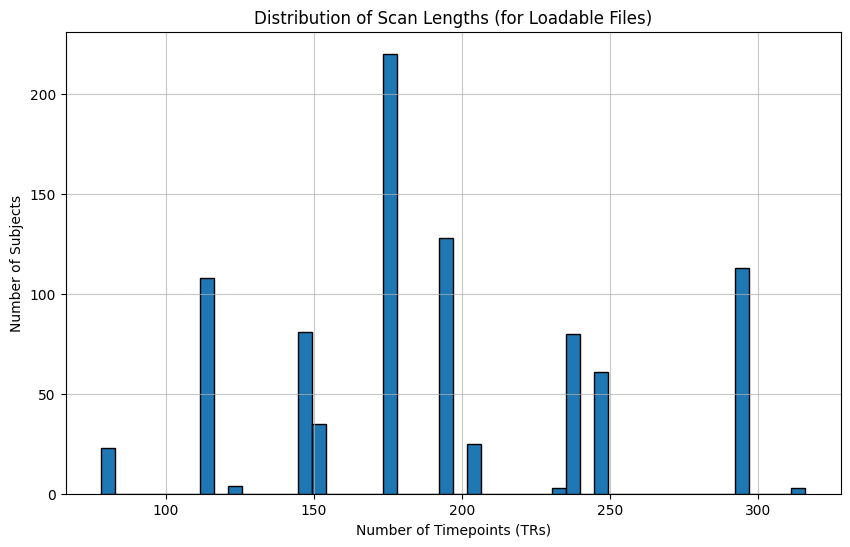

Scan Length Statistics (for 884 subjects):
Min TRs: 78
Max TRs: 316
Mean TRs: 192.20
Median TRs: 176.0
25th Percentile TRs: 152.0
75th Percentile TRs: 236.0


In [ ]:
base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'


tr_counts = []
loadable_file_ids_for_tr_count = []

print("Attempting to load shapes for TR count distribution...")
for index, row in pheno_df_filtered.iterrows():
    file_id = row['FILE_ID']
    subject_file_path = os.path.join(base_1d_files_path, f"{file_id}_{derivative_name}.1D")
    try:
        # Temporarily load without the strict shape filter, just to get TRs if loadable
        timeseries = np.loadtxt(subject_file_path)
        if timeseries.ndim == 2 and timeseries.size > 0 and timeseries.shape[1] == 200:
            tr_counts.append(timeseries.shape[0])
            loadable_file_ids_for_tr_count.append(file_id)

    except Exception as e:
        pass

print(f"Successfully got TR counts for {len(tr_counts)} out of {len(pheno_df_filtered)} files.")

if tr_counts:
    plt.figure(figsize=(10, 6))
    plt.hist(tr_counts, bins=50, edgecolor='black')
    plt.xlabel("Number of Timepoints (TRs)")
    plt.ylabel("Number of Subjects")
    plt.title("Distribution of Scan Lengths (for Loadable Files)")
    plt.grid(True, alpha=0.7)
    plt.show()

    min_tr = np.min(tr_counts)
    max_tr = np.max(tr_counts)
    mean_tr = np.mean(tr_counts)
    median_tr = np.median(tr_counts)
    percentile_25 = np.percentile(tr_counts, 25)
    percentile_75 = np.percentile(tr_counts, 75)

    print(f"Scan Length Statistics (for {len(tr_counts)} subjects):")
    print(f"Min TRs: {min_tr}")
    print(f"Max TRs: {max_tr}")
    print(f"Mean TRs: {mean_tr:.2f}")
    print(f"Median TRs: {median_tr}")
    print(f"25th Percentile TRs: {percentile_25}")
    print(f"75th Percentile TRs: {percentile_75}")

else:
    print("No TR counts could be extracted. Check loading logic or file contents for all 884 files.")

This confirms that the TRs < ROIs heuristic was indeed the reason a large majority of the 884 loadable files were being filtered out, leading to the 285 successfully processed subjects. (The 285 subjects represent roughly 32% of the 884, which aligns with subjects having TRs approximately above the 68th percentile, close to the 75th percentile of 236 TRs).

## Using the 25th Percentile (152 TRs) and above for more subjects:

* Rationale: This is a common approach. It excludes the shortest 25% of scans, which are most likely to yield noisy FC matrices, while retaining 75% of the available loadable subjects.

* Estimated Subjects: 0.75 * 884 subjects = 663 subjects. This would be a significant and very good increase from 285.

As we have a limited dataset, this is the only possible move for this case.

In [4]:
base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'

all_filenames_in_dir = os.listdir(base_1d_files_path)

available_file_ids = set()
for filename in all_filenames_in_dir:
    if filename.endswith(f"_{derivative_name}.1D"):
        file_id = filename.replace(f"_{derivative_name}.1D", "")
        available_file_ids.add(file_id)

pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
pheno_df_full = pd.read_csv(pheno_file_path)
pheno_df_full = pheno_df_full[pheno_df_full['FILE_ID'] != 'no_filename']

pheno_df_filtered = pheno_df_full[pheno_df_full['FILE_ID'].isin(available_file_ids)].copy()

# DX_GROUP: 1 is ASD, 2 is TD.
pheno_df_filtered['label'] = pheno_df_filtered['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

### Defining The New Timeseries Function ( 152<TR ):

In [5]:
# --- Defining the chosen minimum TR threshold ---
MIN_TRS_THRESHOLD = 152 # based on 25th percentile

def load_timeseries_revised(file_path, min_trs):
    """Loads a .1D file into a NumPy array with a minimum TR check."""
    try:
        timeseries = np.loadtxt(file_path)

        if timeseries.size == 0:
            print(f"DEBUG load_timeseries: Loaded empty data from {file_path}.")
            return None
        if timeseries.ndim == 0:
            print(f"DEBUG load_timeseries: Loaded scalar data from {file_path}. Shape: {timeseries.shape}")
            return None


        if timeseries.ndim != 2 or timeseries.shape[1] != 200:
            print(f"DEBUG load_timeseries: Problematic dimensions/ROI count. Shape: {timeseries.shape} for {file_path}")
            return None

        # --- Apply the new minimum TR threshold ---
        if timeseries.shape[0] < min_trs:
            print(f"DEBUG load_timeseries: Insufficient TRs. Shape: {timeseries.shape} (TRs < {min_trs}) for {file_path}")
            return None

        return timeseries
    except Exception as e:
        print(f"DEBUG load_timeseries: Error loading {file_path} with np.loadtxt: {e}")
        return None

### Functional Connectivity Measurement

In [6]:
connectivity_measure = connectome.ConnectivityMeasure(kind='correlation', vectorize=False)

all_fc_matrices_revised = []
subject_ids_for_model_revised = []
labels_for_model_revised = []

successfully_processed_count_revised = 0


for index, row in pheno_df_filtered.iterrows():
    file_id = row['FILE_ID']
    label = row['label']
    subject_file_path = os.path.join(base_1d_files_path, f"{file_id}_{derivative_name}.1D")

    timeseries = load_timeseries_revised(subject_file_path, MIN_TRS_THRESHOLD)

    if timeseries is None:
        continue

    try:
        fc_matrix = connectivity_measure.fit_transform([timeseries])[0]
        all_fc_matrices_revised.append(fc_matrix)
        subject_ids_for_model_revised.append(file_id)
        labels_for_model_revised.append(label)
        successfully_processed_count_revised +=1
    except Exception as e:
        print(f"ERROR during FC calculation for {file_id}: {e}")


print("\n--- Revised Data Processing Summary ---")
print(f"Total subjects initially available (found .1D files): {len(pheno_df_filtered)}")
print(f"Minimum TRs Threshold Applied: {MIN_TRS_THRESHOLD}")
print(f"Successfully processed for FC (final): {successfully_processed_count_revised}")
# The number of skipped files will be len(pheno_df_filtered) - successfully_processed_count_revised

if successfully_processed_count_revised > 0:
    all_fc_matrices_final = np.array(all_fc_matrices_revised)#A NumPy array of shape (668, 200, 200), where each of the 668 entries is a 200x200 functional connectivity matrix for a subject.
    y_final = np.array(labels_for_model_revised)#A NumPy array of shape (668,) containing the corresponding diagnostic labels (0 or 1) for these 668 subjects.
    print(f"Shape of final X (FC matrices collection): {all_fc_matrices_final.shape}")
else:
    print("No subjects passed the revised processing criteria.")

DEBUG load_timeseries: Insufficient TRs. Shape: (78, 200) (TRs < 152) for /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/OHSU_0050142_rois_cc200.1D
DEBUG load_timeseries: Insufficient TRs. Shape: (78, 200) (TRs < 152) for /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/OHSU_0050143_rois_cc200.1D
DEBUG load_timeseries: Insufficient TRs. Shape: (78, 200) (TRs < 152) for /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/OHSU_0050144_rois_cc200.1D
DEBUG load_timeseries: Insufficient TRs. Shape: (78, 200) (TRs < 152) for /content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/OHSU_0050145_rois_cc200.1D
DEBUG load_timeseries: Insufficient TRs. Shape: (78, 200) (TRs < 152) for /content/drive/MyD

It seems like it will work at this point, so we will get back to the original plan and apply a primary Logistic Regression model.

### Prepare Features for Logistic Regression (Flatten FC Matrices):

The all_fc_matrices_final (shape (668, 200, 200)) needs to be converted into a 2D feature matrix X where each row is a subject and each column is a unique connectivity value.

In [7]:
n_subjects = all_fc_matrices_final.shape[0]
n_rois = all_fc_matrices_final.shape[1]

# Get the indices for the upper triangle, excluding the diagonal (k=1)
triu_indices = np.triu_indices(n_rois, k=1)

# to store the flattened feature vectors
X_flattened_list = []

for i in range(n_subjects):
    fc_matrix = all_fc_matrices_final[i]
    flattened_vector = fc_matrix[triu_indices]
    X_flattened_list.append(flattened_vector)

# Convert the list of flattened vectors into a 2D NumPy array
X_for_ml = np.array(X_flattened_list)
y_for_ml = y_final

print(f"Shape of feature matrix X_for_ml: {X_for_ml.shape}")
# Expected shape: (668, N_unique_connections)
# For 200 ROIs, N_unique_connections = (200 * 199) / 2 = 19900
print(f"Shape of label vector y_for_ml: {y_for_ml.shape}")

Shape of feature matrix X_for_ml: (668, 19900)
Shape of label vector y_for_ml: (668,)


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_for_ml, y_for_ml, test_size=0.2, random_state=42, stratify=y_for_ml
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw) # Use transform only on test data

print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

Shape of X_train_scaled: (534, 19900)
Shape of X_test_scaled: (134, 19900)


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # liblinear supports both l1 and l2
}
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=2000), param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_log_reg = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


The key here is C=0.01, which implies stronger L2 regularization. Stronger regularization penalizes larger coefficient values more heavily, often leading to a simpler model that might generalize better and be less prone to overfitting, especially with high-dimensional data.

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(
    penalty='l2', C=0.01, solver='liblinear', random_state=42, max_iter=2000
)# L2 regularization is used for prenalty
log_reg_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained.")

Logistic Regression model trained.


--- Model Performance Evaluation ---

Accuracy: 0.7239

Confusion Matrix:
[[51 22]
 [15 46]]


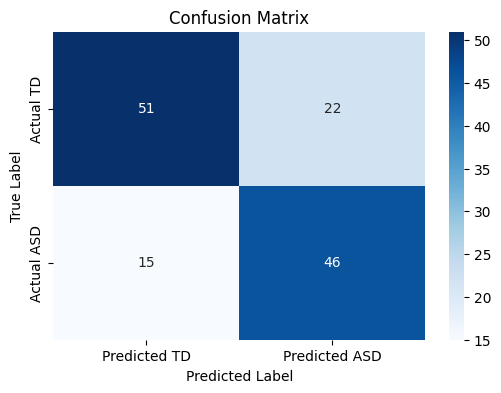


Classification Report:
              precision    recall  f1-score   support

          TD       0.77      0.70      0.73        73
         ASD       0.68      0.75      0.71        61

    accuracy                           0.72       134
   macro avg       0.72      0.73      0.72       134
weighted avg       0.73      0.72      0.72       134


ROC AUC Score: 0.7669


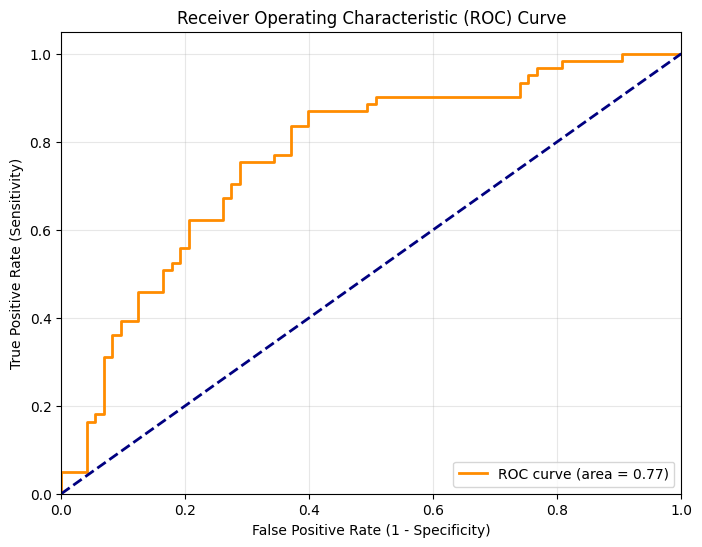

In [12]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Get probability estimates for the positive class (ASD=1)
# This is needed for ROC AUC score and ROC curve
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# --- Calculate and Print Performance Metrics ---
print("--- Model Performance Evaluation ---")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted TD', 'Predicted ASD'],
            yticklabels=['Actual TD', 'Actual ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")

target_names = ['TD', 'ASD']
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Interpreting the Evaluation Metrics:

#### Accuracy: Overall, how often is the classifier correct-->%72.4
It indicates that the functional connectivity features contain relevant information for distinguishing between the groups.

#### Confusion Matrix:

True Negatives (TN): 51 – The model correctly identified 51 TD subjects as TD.

False Positives (FP): 22 – The model incorrectly classified 22 TD subjects as ASD (Type I error).

False Negatives (FN): 15 – The model incorrectly classified 15 ASD subjects as TD (Type II error).

True Positives (TP): 46 – The model correctly identified 46 ASD subjects as ASD.

#### Observations:
The model made more errors misclassifying TD subjects as ASD (24 FPs) than misclassifying ASD subjects as TD (15 FNs).

### Classification Report:

#### For TD Group (Class 0):

* Precision (0.77): When the model predicts a subject is TD, it is correct 77% of the time. (51 / (51+15))

* Recall (0.70): The model correctly identified 70% of all actual TD subjects. (51 / (51+22))

* F1-score (0.73): A harmonic mean of precision and recall for the TD class.
For ASD Group (Class 1):

* Precision (0.68): When the model predicts a subject is ASD, it is correct 68% of the time. (46 / (46+22))
* Recall (0.75): The model correctly identified 75% of all actual ASD subjects. (46 / (46+15))
* F1-score (0.71): A harmonic mean of precision and recall for the ASD class.

Support: The number of actual instances for each class in the test set.

#### Overall Averages:

Accuracy (0.72): Consistent with the overall accuracy.

Macro Avg (0.72 F1-score): Averages the F1-scores of the two classes without considering class imbalance.

Weighted Avg (0.72 F1-score): Averages the F1-scores, weighting by the number of true instances for each class (support: TD=73, ASD=61). The similarity between macro and weighted averages suggests the class distribution in the test set is reasonably balanced.

#### Observations:
The model has a slightly higher recall for ASD (75%) than for TD (70%), meaning it's a bit better at finding most of the ASD cases, but at the cost of lower precision for ASD (68%) – it makes more "false alarms" for ASD.

Conversely, it has higher precision for TD (77%) but misses more TD cases (lower recall for TD).

#### ROC AUC Score: 0.7669

This score measures the model's ability to distinguish between ASD and TD subjects across all classification thresholds.

An AUC of ~0.77 is generally considered fair to acceptable for a biomedical classification task, especially as a first model. It indicates that there's a good chance that the model will rank a randomly chosen ASD subject higher (in terms of probability of being ASD) than a randomly chosen TD subject.


###Overall Performance Summary:
There's a slight tendency to identify ASD cases more readily (higher recall for ASD), but this comes with a higher chance of mislabeling TD individuals as ASD (lower precision for ASD).

In [13]:
best_log_reg_model = grid_search.best_estimator_
coefficients = best_log_reg_model.coef_[0]
print(f"Shape of coefficients array from best_estimator_: {coefficients.shape}")
print(f"Number of features (connections): {len(coefficients)}")

Shape of coefficients array from best_estimator_: (19900,)
Number of features (connections): 19900


In [14]:
# Create a list of (coefficient, feature_index) tuples
feature_coeffs = list(zip(coefficients, range(len(coefficients))))

# Sort by absolute coefficient value in descending order
sorted_feature_coeffs_abs = sorted(feature_coeffs, key=lambda x: abs(x[0]), reverse=True)

print("\nTop 10 most influential connections (by absolute coefficient value) from TUNED MODEL:")
if 'triu_indices' in globals() or 'triu_indices' in locals():
    for i in range(min(10, len(sorted_feature_coeffs_abs))):
        coeff_val, original_feature_idx = sorted_feature_coeffs_abs[i]
        # Map original_feature_idx back to ROI pair using triu_indices
        roi1_idx = triu_indices[0][original_feature_idx]
        roi2_idx = triu_indices[1][original_feature_idx]
        print(f"  Feature Index (flattened): {original_feature_idx}, Coefficient: {coeff_val:.4f}, ROI Pair: ({roi1_idx}, {roi2_idx})")
else:
    print("  'triu_indices' not found. Cannot map feature indices to ROI pairs for absolute coefficients.")

# Sort by actual coefficient value for positive and negative contributors
sorted_coeffs_actual_value = sorted(feature_coeffs, key=lambda x: x[0], reverse=True)

# To get the top 5 positive and top 5 negative contributors
print("\nTop 5 Connections Positively Associated with ASD (Class 1) from TUNED MODEL:")
if 'triu_indices' in globals() or 'triu_indices' in locals():
    count_positive = 0
    for coeff_val, original_feature_idx in sorted_coeffs_actual_value:
        if coeff_val > 0 and count_positive < 5:
            roi1_idx = triu_indices[0][original_feature_idx]
            roi2_idx = triu_indices[1][original_feature_idx]
            print(f"  ROI Pair: ({roi1_idx}, {roi2_idx}), Coefficient: {coeff_val:.4f}")
            count_positive += 1
        elif count_positive >= 5:
            break
    if count_positive == 0:
        print("  No connections found with a positive coefficient strong enough to be in the top.")
else:
    print("  'triu_indices' not found. Cannot map feature indices to ROI pairs for positive coefficients.")


print("\nTop 5 Connections Negatively Associated with ASD (i.e., Positively Associated with TD - Class 0) from TUNED MODEL:")
if 'triu_indices' in globals() or 'triu_indices' in locals():
    count_negative = 0
    # Iterate from the end for most negative (which is the beginning of the list when reverse sorted)
    for coeff_val, original_feature_idx in reversed(sorted_coeffs_actual_value): # Iterate from the end
        if coeff_val < 0 and count_negative < 5:
            roi1_idx = triu_indices[0][original_feature_idx]
            roi2_idx = triu_indices[1][original_feature_idx]
            print(f"  ROI Pair: ({roi1_idx}, {roi2_idx}), Coefficient: {coeff_val:.4f}")
            count_negative += 1
        elif count_negative >=5:
            break
    if count_negative == 0:
         print("  No connections found with a negative coefficient strong enough to be in the top.")
else:
    print("  'triu_indices' not found. Cannot map feature indices to ROI pairs for negative coefficients.")



Top 10 most influential connections (by absolute coefficient value) from TUNED MODEL:
  Feature Index (flattened): 8515, Coefficient: 0.0231, ROI Pair: (48, 140)
  Feature Index (flattened): 5826, Coefficient: 0.0212, ROI Pair: (31, 154)
  Feature Index (flattened): 5797, Coefficient: -0.0203, ROI Pair: (31, 125)
  Feature Index (flattened): 6905, Coefficient: 0.0195, ROI Pair: (38, 85)
  Feature Index (flattened): 5373, Coefficient: 0.0194, ROI Pair: (29, 38)
  Feature Index (flattened): 7804, Coefficient: 0.0191, ROI Pair: (43, 194)
  Feature Index (flattened): 8481, Coefficient: 0.0191, ROI Pair: (48, 106)
  Feature Index (flattened): 4867, Coefficient: 0.0186, ROI Pair: (26, 45)
  Feature Index (flattened): 15003, Coefficient: 0.0184, ROI Pair: (100, 154)
  Feature Index (flattened): 11675, Coefficient: -0.0184, ROI Pair: (71, 103)

Top 5 Connections Positively Associated with ASD (Class 1) from TUNED MODEL:
  ROI Pair: (48, 140), Coefficient: 0.0231
  ROI Pair: (31, 154), Coeffic

1. Magnitude of Coefficients:

The coefficients are relatively small (largest absolute is 0.0231). This is expected with scaled features and L2 regularization, which shrinks coefficients. It doesn't mean they aren't important; their collective pattern drives the classification.

2. Top 10 Most Influential Connections (by absolute coefficient value):
This list shows the connections that, regardless of direction, had the strongest influence on the model's predictions.

3. Top 5 Connections Positively Associated with ASD (Class 1):
For these pairs of ROIs, a stronger functional connection (higher correlation value in the FC matrix) increases the likelihood that the model will classify the subject as ASD.

4. Top 5 Connections Negatively Associated with ASD (i.e., Positively Associated with TD - Class 0):
For these pairs of ROIs, a stronger functional connection decreases the likelihood of being classified as ASD by the model (meaning it's more indicative of a TD subject).



## Anatomical Mapping of ROIs

We were using the CC200 atlas (Cameron Craddock 200 ROIs). These ROIs are functionally defined, meaning they are grouped based on similar fMRI time-series patterns rather than strict anatomical boundaries. While each ROI has a location in MNI space, their "names" provided by the atlas might just be numerical labels (e.g., "Region 1", "Region 2", ..., "Region 200"). Our goal is to get more anatomical context, primarily through their MNI coordinates.


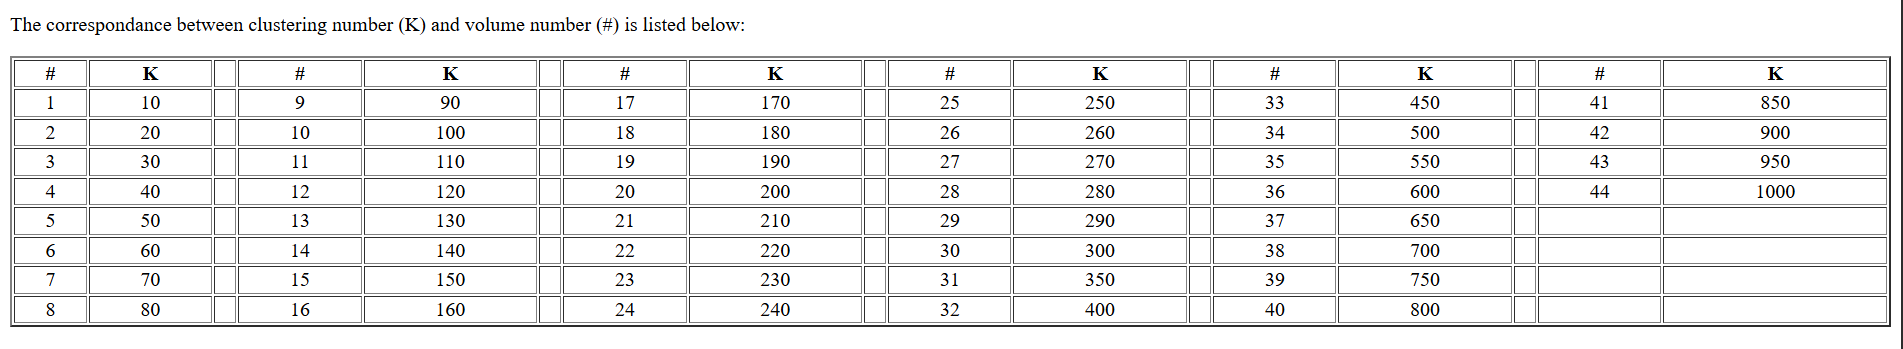

Here we have the mapping table,

* For K = 200 (which means 200 ROIs), the corresponding volume number (#) is 20.

Since volume numbers in such tables are typically 1-indexed, and Python/Nilearn uses 0-indexed slicing for image volumes, the 0-indexed volume we need to extract is 20 - 1 = 19.

The descriptive text also confirms that each NIfTI file contains 44 volumes, and each volume is a different K-level clustering.

From NITRC, we've downloaded the Craddock 2011 set. the next step is to choose the base 4D NIFTI file and here, we will need to provide the correct path to where we've saved this file on the Google Drive.

In [16]:
import os
import numpy as np
from nilearn import image, plotting

atlas_cc200_filepath = "/content/drive/MyDrive/ABIDE_Project/atlases/craddock_K200_vol20_atlas.nii.gz"
n_rois = 200  # Based on the CC200 atlas
coords_for_rois = np.full((n_rois, 3), np.nan) # Initialize with NaNs

if os.path.exists(atlas_cc200_filepath):
    print(f"Loading 3D CC200 atlas from: {atlas_cc200_filepath}")
    try:
        atlas_img = image.load_img(atlas_cc200_filepath)
        print(f"Loaded 3D CC200 atlas with shape: {atlas_img.shape}")

        # Get the unique label values from the atlas data, excluding background (0)
        atlas_data = atlas_img.get_fdata()
        unique_labels_in_atlas = np.unique(atlas_data)
        unique_labels_in_atlas = unique_labels_in_atlas[unique_labels_in_atlas != 0] # Exclude background
        unique_labels_in_atlas.sort() # Ensure labels are sorted for consistent mapping

        print(f"Unique labels found in atlas (excluding background): {unique_labels_in_atlas}")
        print(f"Number of unique labels (ROIs) in atlas: {len(unique_labels_in_atlas)}")

        # Get coordinates for all parcels.
        # find_parcellation_cut_coords returns coordinates ordered by the label values.
        all_parcel_coords = plotting.find_parcellation_cut_coords(
            labels_img=atlas_img,
            background_label=0
        )
        print(f"Found {all_parcel_coords.shape[0]} coordinate sets from find_parcellation_cut_coords.")

        # Map these coordinates to our 0-indexed ROI list (0 to n_rois-1)
        # ROI index `i` (0-199) typically corresponds to label `i+1` in many atlases.
        if len(unique_labels_in_atlas) == all_parcel_coords.shape[0]:
            # Create a mapping from the actual label value to its coordinate
            label_to_coord_map = {label: coord for label, coord in zip(unique_labels_in_atlas, all_parcel_coords)}

            for roi_idx_0_based in range(n_rois):
                label_1_based = roi_idx_0_based + 1 # Convert 0-indexed ROI to 1-indexed label
                if label_1_based in label_to_coord_map:
                    coords_for_rois[roi_idx_0_based] = label_to_coord_map[label_1_based]
                else:
                    print(f"Warning: Label {label_1_based} (for ROI {roi_idx_0_based}) not found in the atlas's unique labels after coordinate extraction. Coordinates will be NaN.")

            num_valid_coords = n_rois - np.sum(np.isnan(coords_for_rois).all(axis=1))
            print(f"\nSuccessfully mapped MNI coordinate sets for {num_valid_coords} out of {n_rois} ROIs.")

            if num_valid_coords != n_rois:
                print("Warning: Some ROIs might not have had their coordinates mapped correctly.")

        elif all_parcel_coords.shape[0] == n_rois and (len(unique_labels_in_atlas) >= n_rois and np.all(unique_labels_in_atlas[:n_rois] == np.arange(1, n_rois + 1))):
            # This case handles if find_parcellation_cut_coords directly returns 200 coords
            # and the labels are sequentially 1 to 200
            print("Assuming direct mapping as number of coords matches n_rois and labels seem sequential from 1 to n_rois.")
            coords_for_rois = all_parcel_coords
            print(f"\nSuccessfully assigned MNI coordinate sets for {coords_for_rois.shape[0]} ROIs.")
        else:
            print("Warning: Mismatch between number of unique labels in atlas data and number of coordinate sets returned, or labels are not sequential from 1 to n_rois.")
            print(f"  Unique labels count: {len(unique_labels_in_atlas)}, Coords found: {all_parcel_coords.shape[0]}")
            coords_for_rois = None # Set to None if mapping is uncertain

        if coords_for_rois is not None:
            # Verification print
            if not np.isnan(coords_for_rois[0]).any():
                 print(f"Example coordinates (for ROI 0, should correspond to atlas label 1): {coords_for_rois[0]}")
            if not np.isnan(coords_for_rois[n_rois-1]).any():
                 print(f"Example coordinates (for ROI {n_rois-1}, should correspond to atlas label {n_rois}): {coords_for_rois[n_rois-1]}")
        else:
            print("Failed to populate 'coords_for_rois' due to mapping issues.")

    except Exception as e:
        print(f"Error during coordinate extraction: {e}")
        coords_for_rois = None
else:
    print(f"Atlas file not found: {atlas_cc200_filepath}. Cannot generate ROI coordinates.")
    coords_for_rois = None

# Check the final state of coords_for_rois
if coords_for_rois is not None:
    print(f"\nShape of generated coords_for_rois: {coords_for_rois.shape}")
    if np.isnan(coords_for_rois).any():
        print(f"Warning: 'coords_for_rois' contains NaN values for {np.sum(np.isnan(coords_for_rois).all(axis=1))} ROIs.")
else:
    print("\n'coords_for_rois' was not generated successfully.")

Loading 3D CC200 atlas from: /content/drive/MyDrive/ABIDE_Project/atlases/craddock_K200_vol20_atlas.nii.gz
Loaded 3D CC200 atlas with shape: (47, 56, 46)
Unique labels found in atlas (excluding background): [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 1

In [17]:
import numpy as np

# Top ROI pairs and coefficients from the model output:
top_positive_pairs_tuned = [(48, 140), (31, 154), (38, 85), (43, 194), (29, 38)]
top_positive_coeffs_tuned = [0.0231, 0.0212, 0.0195, 0.0194, 0.0191]

top_negative_pairs_tuned = [(31, 125), (71, 103), (49, 169), (56, 70), (50, 71)]
top_negative_coeffs_tuned = [-0.0203, -0.0184, -0.0177, -0.0177, -0.0177]


if 'coords_for_rois' in locals() and coords_for_rois is not None:
    print("\n--- MNI Coordinates for Top Connections (from Tuned Model, C=0.01) ---")

    print("\nTop connections POSITIVELY associated with ASD (Class 1):")
    for i, pair in enumerate(top_positive_pairs_tuned):
        roi1_idx, roi2_idx = pair
        coeff = top_positive_coeffs_tuned[i]

        print(f"  ROI Pair: ({roi1_idx}, {roi2_idx}), Coefficient: {coeff:.4f}")

        # Retrieve and print coordinates for ROI 1
        if 0 <= roi1_idx < len(coords_for_rois) and not np.isnan(coords_for_rois[roi1_idx]).any():
            coord1 = coords_for_rois[roi1_idx]
            print(f"    ROI {roi1_idx} MNI Coords: ({coord1[0]:.1f}, {coord1[1]:.1f}, {coord1[2]:.1f})")
        else:
            print(f"    ROI {roi1_idx} MNI Coords: Not available or NaN")

        # Retrieve and print coordinates for ROI 2
        if 0 <= roi2_idx < len(coords_for_rois) and not np.isnan(coords_for_rois[roi2_idx]).any():
            coord2 = coords_for_rois[roi2_idx]
            print(f"    ROI {roi2_idx} MNI Coords: ({coord2[0]:.1f}, {coord2[1]:.1f}, {coord2[2]:.1f})")
        else:
            print(f"    ROI {roi2_idx} MNI Coords: Not available or NaN")

    print("\nTop connections NEGATIVELY associated with ASD (Class 1) / POSITIVELY associated with TD (Class 0):")
    for i, pair in enumerate(top_negative_pairs_tuned):
        roi1_idx, roi2_idx = pair
        coeff = top_negative_coeffs_tuned[i]

        print(f"  ROI Pair: ({roi1_idx}, {roi2_idx}), Coefficient: {coeff:.4f}")

        # Retrieve and print coordinates for ROI 1
        if 0 <= roi1_idx < len(coords_for_rois) and not np.isnan(coords_for_rois[roi1_idx]).any():
            coord1 = coords_for_rois[roi1_idx]
            print(f"    ROI {roi1_idx} MNI Coords: ({coord1[0]:.1f}, {coord1[1]:.1f}, {coord1[2]:.1f})")
        else:
            print(f"    ROI {roi1_idx} MNI Coords: Not available or NaN")

        # Retrieve and print coordinates for ROI 2
        if 0 <= roi2_idx < len(coords_for_rois) and not np.isnan(coords_for_rois[roi2_idx]).any():
            coord2 = coords_for_rois[roi2_idx]
            print(f"    ROI {roi2_idx} MNI Coords: ({coord2[0]:.1f}, {coord2[1]:.1f}, {coord2[2]:.1f})")
        else:
            print(f"    ROI {roi2_idx} MNI Coords: Not available or NaN")
else:
    print("\n'coords_for_rois' array is not defined or is None. Please ensure it was generated successfully.")


--- MNI Coordinates for Top Connections (from Tuned Model, C=0.01) ---

Top connections POSITIVELY associated with ASD (Class 1):
  ROI Pair: (48, 140), Coefficient: 0.0231
    ROI 48 MNI Coords: (61.3, -20.2, -16.2)
    ROI 140 MNI Coords: (-49.8, 23.5, 8.8)
  ROI Pair: (31, 154), Coefficient: 0.0212
    ROI 31 MNI Coords: (43.0, 10.3, -37.0)
    ROI 154 MNI Coords: (21.0, -11.6, -16.8)
  ROI Pair: (38, 85), Coefficient: 0.0195
    ROI 38 MNI Coords: (62.0, -41.9, -8.5)
    ROI 85 MNI Coords: (8.9, -43.6, -37.3)
  ROI Pair: (43, 194), Coefficient: 0.0194
    ROI 43 MNI Coords: (13.3, -94.0, 1.8)
    ROI 194 MNI Coords: (-4.9, -88.4, -14.2)
  ROI Pair: (29, 38), Coefficient: 0.0191
    ROI 29 MNI Coords: (-5.3, -28.4, -37.9)
    ROI 38 MNI Coords: (62.0, -41.9, -8.5)

Top connections NEGATIVELY associated with ASD (Class 1) / POSITIVELY associated with TD (Class 0):
  ROI Pair: (31, 125), Coefficient: -0.0203
    ROI 31 MNI Coords: (43.0, 10.3, -37.0)
    ROI 125 MNI Coords: (35.5, -7

What is special with the results is that the magnitudes of the coefficients give very close results to each other: This means the brain regions and their activities cannot be distiguished with a strict class or a certain activity measure, rather than that the brain regions are active in a way that allows all the brain regions to interact with each other. the key distinction is the time-series which will help us identify where and when these interactions happend and what is different between typical developing and ASD subjects.

This analysis leads us to the conclusion that the best way to identify and make classification is deep learning models where models can capture these subtle, over-time interactions for the best interpretation of the Autism Spectrum Disorder.

### MNI Coordinate Example

**ROI 48 MNI Coordinate**

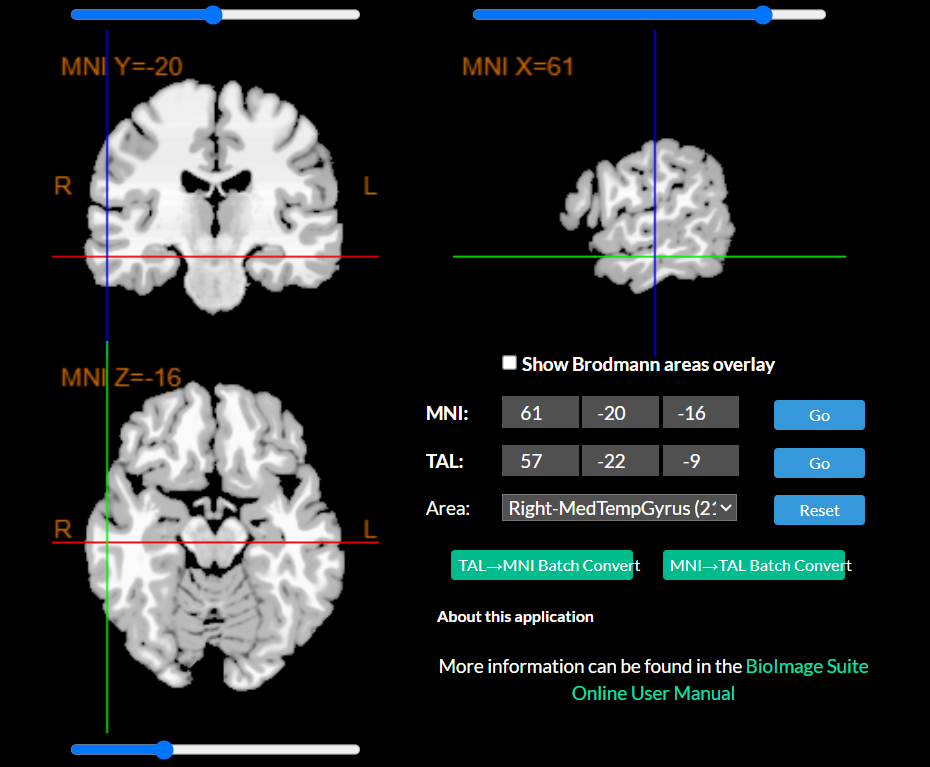

## Playing Around The Models: Tuned Logistic regression and SVM

### Tuned L2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(
    penalty='l2', C=0.001, solver='liblinear', random_state=42, max_iter=2000
)
log_reg_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained.")

Logistic Regression model trained.


--- Model Performance Evaluation ---

Accuracy: 0.7463

Confusion Matrix:
[[52 21]
 [13 48]]


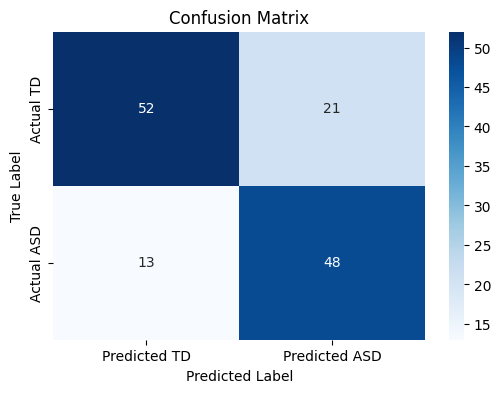


Classification Report:
              precision    recall  f1-score   support

          TD       0.80      0.71      0.75        73
         ASD       0.70      0.79      0.74        61

    accuracy                           0.75       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.75      0.75      0.75       134


ROC AUC Score: 0.7784


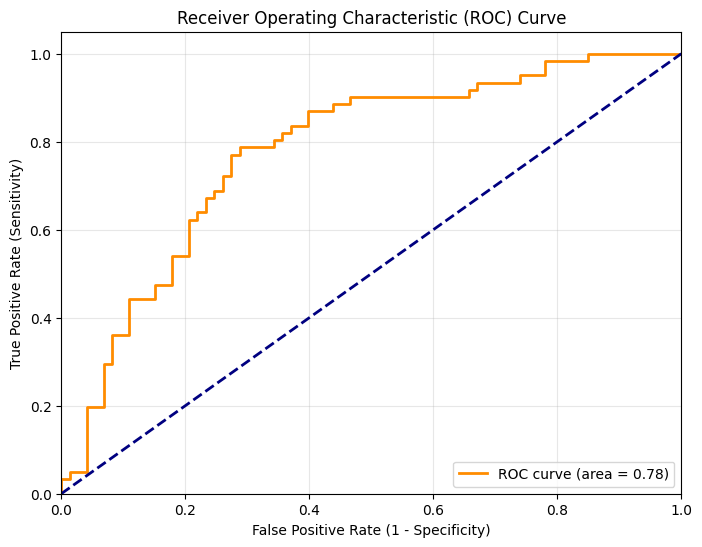

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_scaled)

y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# --- Calculate and Print Performance Metrics ---
print("--- Model Performance Evaluation ---")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted TD', 'Predicted ASD'],
            yticklabels=['Actual TD', 'Actual ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")

target_names = ['TD', 'ASD']
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Using L1 Regularization

In [47]:
log_reg_model = LogisticRegression(
    penalty='l1', C=70, solver='liblinear', random_state=42, max_iter=2000
)#l1 penalty
log_reg_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained.")

Logistic Regression model trained.


--- Model Performance Evaluation ---

Accuracy: 0.7388

Confusion Matrix:
[[53 20]
 [15 46]]


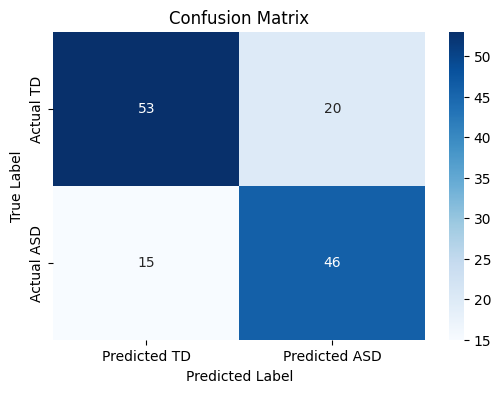


Classification Report:
              precision    recall  f1-score   support

          TD       0.78      0.73      0.75        73
         ASD       0.70      0.75      0.72        61

    accuracy                           0.74       134
   macro avg       0.74      0.74      0.74       134
weighted avg       0.74      0.74      0.74       134


ROC AUC Score: 0.7581


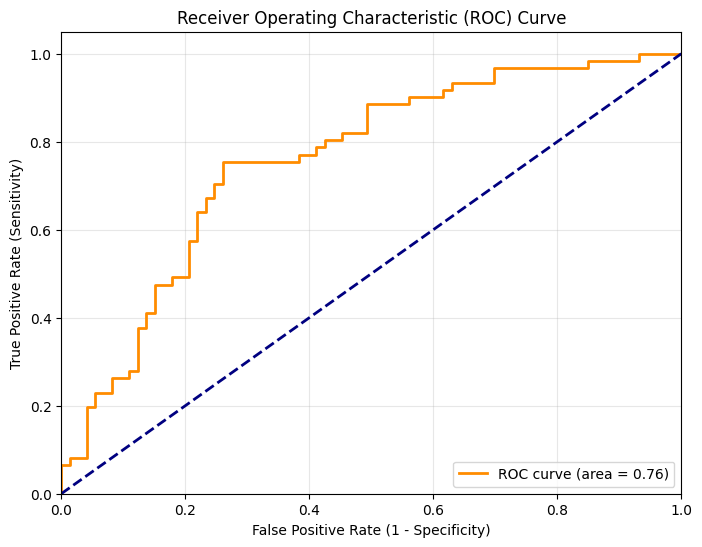

In [48]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Get probability estimates for the positive class (e.g., ASD if ASD=1)
# This is needed for ROC AUC score and ROC curve
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# --- Calculate and Print Performance Metrics ---
print("--- Model Performance Evaluation ---")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted TD', 'Predicted ASD'],
            yticklabels=['Actual TD', 'Actual ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")

target_names = ['TD', 'ASD']
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### SVM with RBF Kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

svm_grid_search = GridSearchCV(SVC(probability=True, random_state=42), # probability=True for ROC AUC
                             svm_param_grid,
                             cv=5,
                             scoring='roc_auc',
                             verbose=2,
                             n_jobs=-1)

# Fit the grid search
svm_grid_search.fit(X_train_scaled, y_train)

print("Best SVM parameters found: ", svm_grid_search.best_params_)
best_svm_model = svm_grid_search.best_estimator_

# --- Evaluate the best SVM model ---
y_pred_svm = best_svm_model.predict(X_test_scaled)
y_pred_proba_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]

accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"\n--- SVM Model Performance ---")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"ROC AUC Score: {roc_auc_svm:.4f}")
print("Confusion Matrix:\n", cm_svm)
print("Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=['TD', 'ASD']))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best SVM parameters found:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

--- SVM Model Performance ---
Accuracy: 0.7090
ROC AUC Score: 0.7673
Confusion Matrix:
 [[54 19]
 [20 41]]
Classification Report:
               precision    recall  f1-score   support

          TD       0.73      0.74      0.73        73
         ASD       0.68      0.67      0.68        61

    accuracy                           0.71       134
   macro avg       0.71      0.71      0.71       134
weighted avg       0.71      0.71      0.71       134



### SVM With Linear Kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel':['linear'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

svm_grid_search = GridSearchCV(SVC(probability=True, random_state=42), # probability=True for ROC AUC
                             svm_param_grid,
                             cv=5,
                             scoring='roc_auc',
                             verbose=2,
                             n_jobs=-1)

# Fit the grid search
svm_grid_search.fit(X_train_scaled, y_train)

print("Best SVM parameters found: ", svm_grid_search.best_params_)
best_svm_model = svm_grid_search.best_estimator_

# --- Evaluate the best SVM model ---
y_pred_svm = best_svm_model.predict(X_test_scaled)
y_pred_proba_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]

accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"\n--- SVM Model Performance ---")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"ROC AUC Score: {roc_auc_svm:.4f}")
print("Confusion Matrix:\n", cm_svm)
print("Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=['TD', 'ASD']))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM parameters found:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}

--- SVM Model Performance ---
Accuracy: 0.7015
ROC AUC Score: 0.7521
Confusion Matrix:
 [[52 21]
 [19 42]]
Classification Report:
               precision    recall  f1-score   support

          TD       0.73      0.71      0.72        73
         ASD       0.67      0.69      0.68        61

    accuracy                           0.70       134
   macro avg       0.70      0.70      0.70       134
weighted avg       0.70      0.70      0.70       134



Comparing the results of all three models (Logistic Regression, RBF SVM, Linear SVM) gives us valuable clues about the dataset:

1. Primarily Linear Signal

2. The success of the heavily regularized Logistic Regression (C=0.001) supports the "curse of dimensionality"; the model performed best when it was forced to penalize complex solutions and keep coefficient values small.

3. Subtle and Distributed Signal: The accuracy levels in the ~70-75% range suggest that the difference between ASD and TD groups isn't defined by a few "smoking gun" connections but is likely a subtle pattern distributed across a wide array of connections. Linear models are often good at finding a weighted combination of many small effects.

4. The RBF kernel SVM, which can model complex, non-linear relationships, did not significantly outperform the linear models. This implies that any non-linear patterns are either not strong enough to be useful or the model couldn't find them amidst the noise of the high-dimensional feature space.


### Feature Selection

We will use the Analysis of Variance (ANOVA) F-test as our feature selection method. It's a fast and effective univariate method that tests for a significant difference in the means of each feature between the two classes (ASD vs. TD). We'll select the k features with the highest F-scores.

In [75]:
from sklearn.feature_selection import SelectKBest, f_classif

# --- 1. Define the Feature Selector ---
# A good starting point is often between 1-5% of the total features.
k_best_features = 10500
selector = SelectKBest(score_func=f_classif, k=k_best_features)

# --- 2. Fit the selector on the training data and transform ---
# This learns which features are the best from the training set
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# --- 3. Transform the test data using the same fitted selector ---
# This applies the same feature selection learned from the training set
X_test_selected = selector.transform(X_test_scaled)

# --- 4. Verify the new shapes ---
print(f"Original feature shape: {X_train_scaled.shape}")
print(f"Shape after selecting top {k_best_features} features: {X_train_selected.shape}")
print(f"Test data shape after transformation: {X_test_selected.shape}")


selected_indices = selector.get_support(indices=True)
print("\nIndices of the top 10 selected features:", selected_indices[:10])

Original feature shape: (534, 19900)
Shape after selecting top 10500 features: (534, 10500)
Test data shape after transformation: (134, 10500)

Indices of the top 10 selected features: [ 0  1  3  5  7  8 10 11 12 13]


In [76]:
from sklearn.linear_model import LogisticRegression

# --- 1. Train the previous best Logistic Regression model on the SELECTED features ---
log_reg_selected = LogisticRegression(penalty='l1', C=70, solver='liblinear', random_state=42, max_iter=2000)
log_reg_selected.fit(X_train_selected, y_train)

# --- 2. Evaluate the model ---
y_pred_lr_selected = log_reg_selected.predict(X_test_selected)
y_pred_proba_lr_selected = log_reg_selected.predict_proba(X_test_selected)[:, 1]

# --- 3. Display Performance Metrics ---
accuracy_lr_selected = accuracy_score(y_test, y_pred_lr_selected)
roc_auc_lr_selected = roc_auc_score(y_test, y_pred_proba_lr_selected)
cm_lr_selected = confusion_matrix(y_test, y_pred_lr_selected)

print(f"\n--- Logistic Regression Performance on {k_best_features} Selected Features ---")
print(f"Accuracy: {accuracy_lr_selected:.4f}")
print(f"ROC AUC Score: {roc_auc_lr_selected:.4f}")
print("Confusion Matrix:\n", cm_lr_selected)
print("Classification Report:\n", classification_report(y_test, y_pred_lr_selected, target_names=['TD', 'ASD']))


--- Logistic Regression Performance on 10500 Selected Features ---
Accuracy: 0.7090
ROC AUC Score: 0.7647
Confusion Matrix:
 [[51 22]
 [17 44]]
Classification Report:
               precision    recall  f1-score   support

          TD       0.75      0.70      0.72        73
         ASD       0.67      0.72      0.69        61

    accuracy                           0.71       134
   macro avg       0.71      0.71      0.71       134
weighted avg       0.71      0.71      0.71       134



In [78]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# --- 1. Define the SVM model and parameter grid ---
svm_linear_param_grid = {'C': [0.01,0.1,1,10,50]}

# --- 2. Perform Grid Search on the SELECTED features ---
svm_linear_grid_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42),
                                     svm_linear_param_grid,
                                     cv=5,
                                     scoring='roc_auc',
                                     verbose=1,
                                     n_jobs=-1)

svm_linear_grid_search.fit(X_train_selected, y_train)

# --- 3. Get the best model and evaluate ---
print("\nBest Linear SVM parameters found: ", svm_linear_grid_search.best_params_)
best_linear_svm = svm_linear_grid_search.best_estimator_

y_pred_svm_linear = best_linear_svm.predict(X_test_selected)
y_pred_proba_svm_linear = best_linear_svm.predict_proba(X_test_selected)[:, 1]

# --- 4. Display Performance Metrics ---
accuracy_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
roc_auc_svm_linear = roc_auc_score(y_test, y_pred_proba_svm_linear)
cm_svm_linear = confusion_matrix(y_test, y_pred_svm_linear)

print(f"\n--- Linear SVM Performance on {k_best_features} Selected Features ---")
print(f"Accuracy: {accuracy_svm_linear:.4f}")
print(f"ROC AUC Score: {roc_auc_svm_linear:.4f}")
print("Confusion Matrix:\n", cm_svm_linear)
print("Classification Report:\n", classification_report(y_test, y_pred_svm_linear, target_names=['TD', 'ASD']))

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Linear SVM parameters found:  {'C': 0.01}

--- Linear SVM Performance on 10500 Selected Features ---
Accuracy: 0.6866
ROC AUC Score: 0.7438
Confusion Matrix:
 [[53 20]
 [22 39]]
Classification Report:
               precision    recall  f1-score   support

          TD       0.71      0.73      0.72        73
         ASD       0.66      0.64      0.65        61

    accuracy                           0.69       134
   macro avg       0.68      0.68      0.68       134
weighted avg       0.69      0.69      0.69       134



The results show that for our dataset, a simple feature selection method like SelectKBest actually degraded the performance of the models.

The assumption "fewer features is always better" does not hold true. The key is not just having fewer features, but having the right features.

1. The Signal is Distributed and Multivariate:
The difference between ASD and TD individuals isn't caused by a few "superstar" connections that are highly predictive on their own. Instead, the signal is likely a subtle pattern distributed across hundreds or even thousands of connections. A univariate method like the ANOVA F-test (used by SelectKBest) evaluates each feature in isolation. It might discard many "weak" features that, while not very predictive individually, are valuable when combined.

2. The Power of Regularization vs. Hard Feature Removal:
L2 regularization works by shrinking the coefficients of less important features towards zero but it doesn't completely remove them. This "down-weighting" strategy appears to be superior for the dataset compared to the "hard removal" performed by SelectKBest. It allows the model to still leverage the small contributions from many features, which seems to be where the real signal lies.



### Recursive Feature Elimination with Cross-Validation (RFECV)

How does RFECV work?
Instead of evaluating features one by one, RFECV does the following:

* Trains a model on all features.
* Ranks the features by importance (by the size of their coefficients).
* Removes the least important feature(s).
* Repeats the process until a desired number of features is left.
* Crucially, it uses cross-validation at each step to determine which number of features yields the best model performance.



In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# --- 1. Define the estimator and the RFECV object ---
# We use your best model as the estimator to evaluate the feature importance
estimator = LogisticRegression(penalty='l2', C=0.001, solver='liblinear', random_state=42, max_iter=2000)

# The RFECV object will use cross-validation to find the optimal number of features.
# 'step=100' means it will remove 100 features at each iteration (faster than removing 1).
# 'min_features_to_select' is a sensible lower bound.
rfecv_selector = RFECV(estimator=estimator,
                     step=100,
                     cv=StratifiedKFold(3), # Using 3 folds for speed, 5 is also fine
                     scoring='roc_auc',
                     min_features_to_select=500,
                     verbose=1,
                     n_jobs=-1)

# --- 2. Fit RFECV on the original training data ---
print("Starting RFECV... This may take a while.")
rfecv_selector.fit(X_train_scaled, y_train)
print("RFECV fitting completed.")

# --- 3. Report the optimal number of features found ---
print(f"\nOptimal number of features found by RFECV: {rfecv_selector.n_features_}")

# --- 4. Transform the data to the optimal feature set ---
X_train_rfecv = rfecv_selector.transform(X_train_scaled)
X_test_rfecv = rfecv_selector.transform(X_test_scaled)

# --- 5. Train and evaluate the final model on the RFECV-selected features ---
final_model = LogisticRegression(penalty='l2', C=0.01, solver='liblinear', random_state=42, max_iter=2000)
final_model.fit(X_train_rfecv, y_train)

# --- Evaluation ---
y_pred_final = final_model.predict(X_test_rfecv)
y_pred_proba_final = final_model.predict_proba(X_test_rfecv)[:, 1]

accuracy_final = accuracy_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)

print(f"\n--- Model Performance on RFECV Selected Features ---")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"ROC AUC Score: {roc_auc_final:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_final, target_names=['TD', 'ASD']))

Starting RFECV... This may take a while.
Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 

In [80]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# --- 1. Define the SVM estimator for RFECV ---
# We must use a linear kernel so that RFECV can access feature importances (coefficients).
svm_estimator = SVC(kernel='linear', C=1)

# --- 2. Define the RFECV object with the SVM estimator ---
rfecv_svm_selector = RFECV(estimator=svm_estimator,
                           step=100,
                           cv=StratifiedKFold(3),
                           scoring='roc_auc',
                           min_features_to_select=500,
                           verbose=1,
                           n_jobs=-1)

# --- 3. Fit RFECV on the original training data ---
print("Starting RFECV with SVM estimator... This may take a while.")
rfecv_svm_selector.fit(X_train_scaled, y_train)
print("RFECV fitting completed.")

# --- 4. Report the optimal number of features ---
print(f"\nOptimal number of features found by SVM-RFECV: {rfecv_svm_selector.n_features_}")

# --- 5. Transform your data to the optimal feature set ---
X_train_svm_rfecv = rfecv_svm_selector.transform(X_train_scaled)
X_test_svm_rfecv = rfecv_svm_selector.transform(X_test_scaled)

# --- 6. Tune and train the final SVM model on the selected features ---
svm_param_grid = {'C': [0.01,0.1, 1, 10]}

final_svm_grid = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42),
                              svm_param_grid,
                              cv=5,
                              scoring='roc_auc',
                              n_jobs=-1)

final_svm_grid.fit(X_train_svm_rfecv, y_train)
best_final_svm = final_svm_grid.best_estimator_
print("\nBest C for final SVM on selected features:", final_svm_grid.best_params_['C'])


# --- 7. Evaluate the final model ---
y_pred_svm_final = best_final_svm.predict(X_test_svm_rfecv)
y_pred_proba_svm_final = best_final_svm.predict_proba(X_test_svm_rfecv)[:, 1]

accuracy_svm_final = accuracy_score(y_test, y_pred_svm_final)
roc_auc_svm_final = roc_auc_score(y_test, y_pred_proba_svm_final)
cm_svm_final = confusion_matrix(y_test, y_pred_svm_final)

print(f"\n--- Final SVM Performance on RFECV Selected Features ---")
print(f"Accuracy: {accuracy_svm_final:.4f}")
print(f"ROC AUC Score: {roc_auc_svm_final:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm_final, target_names=['TD', 'ASD']))

Starting RFECV with SVM estimator... This may take a while.
Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitt

## This Notebook's Findings

1. Finding: A heavily regularized Logistic Regression (C=0.001, L2 penalty) applied to the full feature set (19,900 connections) was the best-performing model, achieving ~75% accuracy and a ~0.78 ROC AUC score.

* Contribution: This establishes a strong, clear performance benchmark. Any future model, including the planned CNN/RNN, must outperform this score to be considered an improvement.

2. Finding: Both simple univariate feature selection (SelectKBest) and advanced multivariate feature selection (RFECV) resulted in a decrease in performance compared to the regularized model using all features.

* Contribution: This generates a powerful hypothesis about the data: **The predictive signal is subtle and widely distributed across the brain's functional network**. There are no single "dscriminative" connections; rather, it's the combined pattern of many weak signals that allows for classification.

3. Finding: The RFECV model determined that an optimal subset contained 2100 features. While this model didn't beat the benchmark, it provides us with a much smaller, highly-relevant set of features.

* Contribution: This smaller feature set is now perfect for efficiently training more complex, non-linear models (like Random Forest, XGBoost, or an RBF-kernel SVM) that would have been too computationally expensive to run on the full 19,900 features.

4. Finding: We identified the top ROI pairs (and their MNI coordinates) that were most predictive of ASD (positive coefficients) and TD (negative coefficients).

* Contribution: This is the first step towards the project's ultimate aim of finding objective neuroimaging-based biomarkers. These specific connections can now be investigated further from a neuroscientific perspective.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

**Key Takeaways of the Findings:**

Regularization can be more powerful than feature removal in high-dimensional neuroimaging data where the signal is distributed.
A simple linear model can be a surprisingly strong baseline. It's crucial to establish this before moving to more complex deep learning models.
The models has successfully demonstrated that functional connectivity patterns contain sufficient information to classify ASD vs. TD with ~75% accuracy, validating the core premise of the research.

**We now have a clear target (75% accuracy) for the more advanced deep learning models to surpass!**